# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model.

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [4]:
with open('wordlist.txt', 'r') as f:
    words = f.read().splitlines()

def pad_word(word):
    return word + '_' * (WORD_SIZE - len(word))

vocab = [pad_word(word.lower()) for word in words if 3 < len(word) <= WORD_SIZE]

print(len(vocab),"words are in vocab")
print(vocab[:10])

8847 words are in vocab
['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______', 'able_________', 'aboriginal___', 'abortion_____', 'about________', 'above________']


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer**

I think limiting words to those longer than 3 letters and up to a maximum length helps reduce computational complexity and memory usage during training. Short words often carry less meaningful information for autocompletion tasks, and very long words can introduce unnecessary complexity. By standardizing word lengths (padding shorter words), we simplify the model's input, making it easier to train and potentially improving its performance by focusing on words most relevant for autocompletion.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [5]:
def char_to_num(char):
    # Map underscore to 0
    # Map 'a' to 1, 'b' to 2, ..., 'z' to 26
    if char == '_':
        return 0
    else:
        return ord(char) - ord('a') + 1

def num_to_char(num):
    # Map 0 to underscore
    # Map 1 to 'a', 2 to 'b', ..., 26 to 'z'
    if num == 0:
        return '_'
    else:
        return chr(num + ord('a') - 1)

def word_to_numlist(word):
    numlist = [char_to_num(char) for char in word]
    numlist = torch.tensor(numlist, dtype=torch.long)
    return numlist

def numlist_to_word(numlist):
    # Ensure numlist is a Python list
    if isinstance(numlist, torch.Tensor):
        numlist = numlist.tolist()
    word = ''.join([num_to_char(num) for num in numlist])
    return word

print("united_______", word_to_numlist("united_______"))
print("[21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]",numlist_to_word([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]))

united_______ tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0])
[21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0] united_______


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer**

The claim is valid. Assigning numerical values to letters based on their alphabetical order introduces an unintended ordinal relationship between them. Since letters are categorical data, this encoding suggests that 'b' (2) is somehow greater than 'a' (1), which doesn't make sense linguistically. This can mislead learning models that interpret numerical inputs as having inherent magnitude or order, potentially degrading performance.

An embedding layer addresses this issue by mapping each categorical input (like letters) to a dense vector of real numbers in a continuous vector space. The purpose of an embedding layer is to capture semantic relationships among categories without imposing arbitrary numerical order. It allows the model to learn meaningful representations of the input data, improving its ability to recognize patterns and make accurate predictions.

Articles which I read for this part :

  - [Encoding Categorical Data, Explained: A Visual Guide with Code Example for Beginners](https://towardsdatascience.com/encoding-categorical-data-explained-a-visual-guide-with-code-example-for-beginners-b169ac4193ae)

  - [How to Deal with Categorical Data for Machine Learning](https://www.kdnuggets.com/2021/05/deal-with-categorical-data-machine-learning.html)

  - [Neural Network Embeddings Explained](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526)


## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [6]:
LEARNING_RATE = 0.005

In [7]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters
        self.alphabet_size = alphabet_size  # Number of unique characters
        self.embed_dim = embed_dim          # Dimension of the embedding vector
        self.hidden_size = hidden_size      # Number of features in the hidden state
        self.num_layers = num_layers        # Number of recurrent layers (LSTM layers)

        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation
        self.embedding = nn.Embedding(num_embeddings=alphabet_size, embedding_dim=embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, alphabet_size)

    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        embedded = self.embedding(character.unsqueeze(0))  # Shape: [1, 1, embed_dim]

        #2. Feed the embedded output to the LSTM cell
        output, (hidden_state, cell_state) = self.lstm(embedded, (hidden_state, cell_state)) # output shape: [1, 1, hidden_size]

        #3. Feed the LSTM output to the fully connected layer to obtain the output
        output = self.fc(output.squeeze(0))  # Shape: [1, alphabet_size]

        #4. return the output, and both the hidden state and cell state from the LSTM cell output
        return output, hidden_state, cell_state

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):

        # Batch size is 1 since we're processing one word at a time
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (h0, c0)

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        for e in range(epochs):

            #Shuffle the vocab list the start of each epoch
            random.shuffle(vocab)
            num_iter = len(vocab) // batch_size

            for i in range(num_iter):

                #TODO: Set the loss to zero, initialize the optimizer with zero_grad at the beginning of each training cycle.
                vocab_batch = vocab[i * batch_size : (i + 1) * batch_size]
                optimizer.zero_grad()
                total_loss = 0  # Accumulate loss over the batch

                for word in vocab_batch:

                    #TODO: Initialize the hidden state and cell state at the start of each word.
                    hidden_state, cell_state = self.initial_state()

                    #TODO: Convert the word into a tensor of number and create input and target from the word
                    numlist = word_to_numlist(word)
                    # Input: first WORD_SIZE - 1 characters
                    # Target: last WORD_SIZE - 1 characters
                    inputs = numlist[:-1]   # Exclude last character
                    targets = numlist[1:]   # Exclude first character

                    #Loop through each character (as a number) in the word
                    for c in range(WORD_SIZE - 1):

                        input_char = inputs[c].unsqueeze(0)    # Shape: [1]
                        target_char = targets[c].unsqueeze(0)  # Shape: [1]

                        # Feed the cth character to the model (feedforward)
                        output, hidden_state, cell_state = self.forward(input_char, hidden_state, cell_state)

                        # Compute the loss (use cross-entropy)
                        loss = nn.CrossEntropyLoss()(output, target_char)
                        total_loss += loss



                #TODO: Compute the average loss per word in the batch and perform backpropagation (.backward())
                average_loss = total_loss / batch_size
                average_loss.backward()

                #TODO: Update model parameters using the optimizer
                optimizer.step()

                #Update the loss_log
                loss_log.append(average_loss.item())

            print(f"Epoch {e+1}/{epochs}, Loss: {average_loss.item():.4f}")

        #TODO Plot a graph of the variation of the loss.
        plt.plot(loss_log)
        plt.xlabel('Training Iterations')
        plt.ylabel('Loss')
        plt.title('Training Loss over Time')
        plt.show()

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):

        #Convert the model into evaluation mode
        self.eval()
        completed_list = []

        #TODO: In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial
        for literal in sample:
            hidden_state, cell_state = self.initial_state()

            # Convert the input literal to a tensor of numbers
            input_chars = [char_to_num(c) for c in literal]
            input_tensor = torch.tensor(input_chars, dtype=torch.long)

            # Feed the input characters through the model to update hidden and cell states
            for idx in input_tensor:
                idx = idx.unsqueeze(0)  # Shape: [1]
                output, hidden_state, cell_state = self.forward(idx, hidden_state, cell_state)

            # Now, predict the rest of the characters up to WORD_SIZE
            predicted_chars = []
            current_char = input_tensor[-1]

            for _ in range(len(literal), WORD_SIZE):
                # Apply softmax to get probabilities
                output_probs = nn.functional.softmax(output, dim=1)

                # Sample from the distribution
                next_char_idx = torch.multinomial(output_probs, num_samples=1).item()

                # Append the predicted character index
                predicted_chars.append(next_char_idx)

                # Prepare next input
                input_char = torch.tensor([next_char_idx], dtype=torch.long)

                # Feed the next character into the model
                output, hidden_state, cell_state = self.forward(input_char, hidden_state, cell_state)

            # Convert the predicted character indices to characters
            predicted_word = literal + ''.join([num_to_char(idx) for idx in predicted_chars])

            # Append the completed word to the list
            completed_list.append(predicted_word)
        return completed_list


## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

**Answer** (to write answers edit this cell)

In [8]:
ALPHABET_SIZE = 27    # 26 letters + underscore

combinations = [
    { 'EMBED_DIM': 64, 'HIDDEN_SIZE': 128, 'NUM_LAYERS': 1, 'EPOCHS': 15, 'BATCH_SIZE': 128 },
    { 'EMBED_DIM': 64, 'HIDDEN_SIZE': 128, 'NUM_LAYERS': 1, 'EPOCHS': 15, 'BATCH_SIZE': 64 },
    { 'EMBED_DIM': 64, 'HIDDEN_SIZE': 128, 'NUM_LAYERS': 2, 'EPOCHS': 15, 'BATCH_SIZE': 64 },
    { 'EMBED_DIM': 64, 'HIDDEN_SIZE': 256, 'NUM_LAYERS': 2, 'EPOCHS': 15, 'BATCH_SIZE': 64 },
]


EMBED_DIM: 64, HIDDEN_SIZE: 128, NUM_LAYERS: 1, EPOCHS: 15, BATCH_SIZE: 128
Epoch 1/15, Loss: 15.5947
Epoch 2/15, Loss: 14.9551
Epoch 3/15, Loss: 13.3713
Epoch 4/15, Loss: 13.8617
Epoch 5/15, Loss: 13.2475
Epoch 6/15, Loss: 11.6375
Epoch 7/15, Loss: 11.8934
Epoch 8/15, Loss: 11.4693
Epoch 9/15, Loss: 11.5409
Epoch 10/15, Loss: 10.8408
Epoch 11/15, Loss: 10.7736
Epoch 12/15, Loss: 10.6840
Epoch 13/15, Loss: 10.5913
Epoch 14/15, Loss: 10.0900
Epoch 15/15, Loss: 9.7546


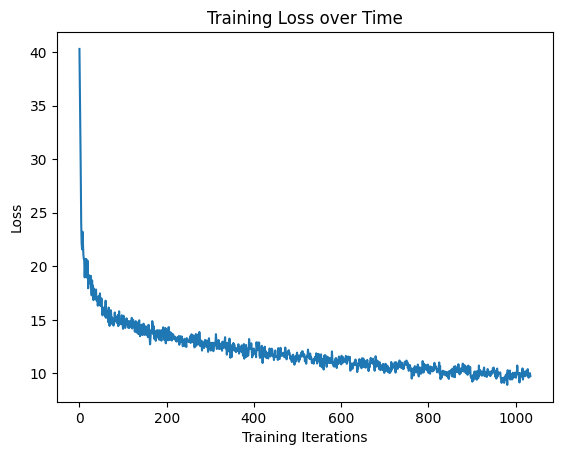


EMBED_DIM: 64, HIDDEN_SIZE: 128, NUM_LAYERS: 1, EPOCHS: 15, BATCH_SIZE: 64
Epoch 1/15, Loss: 13.9184
Epoch 2/15, Loss: 15.1062
Epoch 3/15, Loss: 13.2317
Epoch 4/15, Loss: 13.1208
Epoch 5/15, Loss: 12.4023
Epoch 6/15, Loss: 11.9604
Epoch 7/15, Loss: 11.9133
Epoch 8/15, Loss: 11.2389
Epoch 9/15, Loss: 10.8471
Epoch 10/15, Loss: 9.8950
Epoch 11/15, Loss: 9.9453
Epoch 12/15, Loss: 10.1645
Epoch 13/15, Loss: 9.7823
Epoch 14/15, Loss: 9.7162
Epoch 15/15, Loss: 9.2689


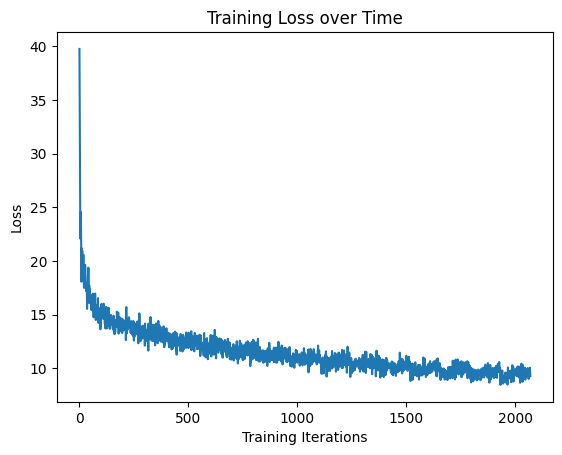


EMBED_DIM: 64, HIDDEN_SIZE: 128, NUM_LAYERS: 2, EPOCHS: 15, BATCH_SIZE: 64
Epoch 1/15, Loss: 14.5990
Epoch 2/15, Loss: 14.3836
Epoch 3/15, Loss: 13.0899
Epoch 4/15, Loss: 12.9519
Epoch 5/15, Loss: 11.6103
Epoch 6/15, Loss: 10.7315
Epoch 7/15, Loss: 11.3338
Epoch 8/15, Loss: 10.1124
Epoch 9/15, Loss: 9.8230
Epoch 10/15, Loss: 9.1497
Epoch 11/15, Loss: 9.0396
Epoch 12/15, Loss: 8.9839
Epoch 13/15, Loss: 8.7224
Epoch 14/15, Loss: 9.0990
Epoch 15/15, Loss: 8.4656


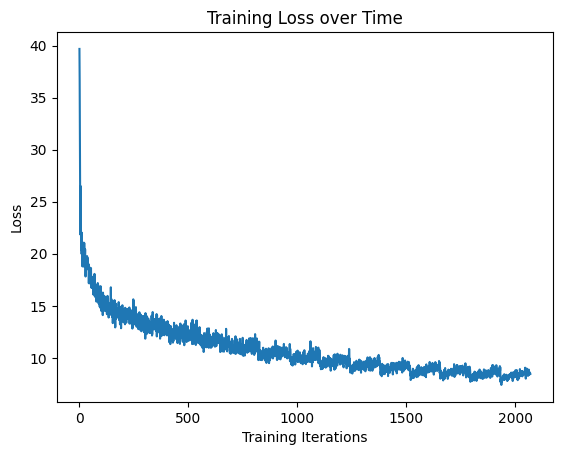


EMBED_DIM: 64, HIDDEN_SIZE: 256, NUM_LAYERS: 2, EPOCHS: 15, BATCH_SIZE: 64
Epoch 1/15, Loss: 14.5324
Epoch 2/15, Loss: 12.9875
Epoch 3/15, Loss: 11.7324
Epoch 4/15, Loss: 12.0144
Epoch 5/15, Loss: 10.3036
Epoch 6/15, Loss: 10.5340
Epoch 7/15, Loss: 10.0373
Epoch 8/15, Loss: 9.3050
Epoch 9/15, Loss: 8.4530
Epoch 10/15, Loss: 8.6613
Epoch 11/15, Loss: 8.1719
Epoch 12/15, Loss: 8.4083
Epoch 13/15, Loss: 8.2458
Epoch 14/15, Loss: 7.8372
Epoch 15/15, Loss: 8.0835


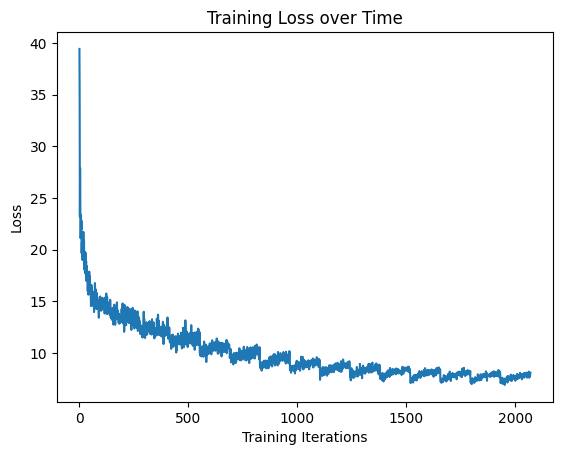

In [9]:
# List to store trained models
trained_models = []

for i in range(len(combinations)):
    EMBED_DIM , HIDDEN_SIZE, NUM_LAYERS, EPOCHS, BATCH_SIZE = combinations[i].values()
    print( f"\nEMBED_DIM: {EMBED_DIM}, HIDDEN_SIZE: {HIDDEN_SIZE}, NUM_LAYERS: {NUM_LAYERS}, EPOCHS: {EPOCHS}, BATCH_SIZE: {BATCH_SIZE}")
    new_model = autocompleteModel(ALPHABET_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS)
    new_model.trainModel(vocab, epochs=EPOCHS, batch_size=BATCH_SIZE)
    trained_models.append(new_model)


I tried with several combinations and the model with  { 'EMBED_DIM': 64, 'HIDDEN_SIZE': 256, 'NUM_LAYERS': 2, 'EPOCHS': 15, 'BATCH_SIZE': 64 } parameters has the minimum loss at the end of training. The loss decreasing from 14.53 to around 8.08 over 15 epochs indicates that the model is learning patterns from the data.

Let's Evaluate the Model on Sample Inputs

In [10]:
# Sample inputs for testing to get an idea
samples = [
    'pro', 'data', 'info', 'tech', 'syst', 'netw', 'comp', 'prog', 'algo', 'arch',
    'math', 'phys', 'chem', 'biol', 'geol', 'astr', 'econ', 'stat', 'phil', 'hist',
    'psyc', 'soci', 'anth', 'ling', 'educ', 'medi', 'nurs', 'engi', 'art', 'mus',
    'dram', 'film', 'lite', 'poet', 'danc', 'pain', 'scul', 'phot', 'spor', 'game',
    'hobb', 'trav', 'food', 'cook', 'bake', 'rest', 'shop', 'fash', 'desi', 'mode',
    'clot', 'jew', 'acce', 'auto', 'moto', 'bike', 'plan', 'boat', 'trai', 'bus',
    'tax', 'wal', 'run', 'clim', 'swim', 'div', 'sai', 'hik', 'camp', 'fis', 'hun',
    'gard', 'farm', 'anim', 'bir', 'inse', 'pla', 'tre', 'flo', 'roc', 'min',
    'weat', 'clim', 'env', 'cons', 'pol', 'sust', 'ene', 'nat', 'wil', 'oce',
    'riv', 'lak', 'mou', 'des', 'isl', 'coa', 'hea', 'bod', 'min', 'spi', 'emo'
]

completed_words = trained_models[3].autocomplete(samples)

print("Autocomplete Results:")
print(f"Input:\t-> \tCompleted:")
correct = 0
for i, sample in enumerate(samples):
    msg = ""
    if completed_words[i] in vocab:
        msg = "(In Vocab)"
        correct += 1

    print(f"{sample}\t-> \t {completed_words[i]} \t {msg}")

Autocomplete Results:
Input:	-> 	Completed:
pro	-> 	 produck______ 	 
data	-> 	 data_________ 	 (In Vocab)
info	-> 	 inform_______ 	 (In Vocab)
tech	-> 	 techmonial___ 	 
syst	-> 	 systemal_____ 	 
netw	-> 	 network______ 	 (In Vocab)
comp	-> 	 competation__ 	 
prog	-> 	 programmers__ 	 (In Vocab)
algo	-> 	 algories_____ 	 
arch	-> 	 architects___ 	 (In Vocab)
math	-> 	 mathematicall 	 
phys	-> 	 phys_________ 	 (In Vocab)
chem	-> 	 chemed_______ 	 
biol	-> 	 bioleve______ 	 
geol	-> 	 geology______ 	 (In Vocab)
astr	-> 	 astrology____ 	 (In Vocab)
econ	-> 	 economic_____ 	 (In Vocab)
stat	-> 	 statistical__ 	 (In Vocab)
phil	-> 	 philips______ 	 (In Vocab)
hist	-> 	 historic_____ 	 (In Vocab)
psyc	-> 	 psych________ 	 
soci	-> 	 societies____ 	 (In Vocab)
anth	-> 	 anthony______ 	 (In Vocab)
ling	-> 	 lingerine____ 	 
educ	-> 	 educes_______ 	 
medi	-> 	 median_______ 	 (In Vocab)
nurs	-> 	 nurseston____ 	 
engi	-> 	 engines______ 	 (In Vocab)
art	-> 	 arthun_______ 	 
mus	-> 	 musici

In [11]:
print(f"{correct}/{len(samples)} | {correct/len(samples)*100}%")

67/102 | 65.68627450980392%


 **Answer:**

 The model with following parameters has the minimum loss.

    - EMBED_DIM   : 64
    - HIDDEN_SIZE : 256
    - NUM_LAYERS  : 2
    - EPOCHS      : 15
    - BATCH_SIZE  : 64

 The loss decreasing from  14.53 to around 8.08 over 15 epochs indicates that the model is learning patterns from the data.


 And the generated text likely includes familiar substrings like "ed", "tion", "ing", and "able", which suggests the model has captured common English word endings and morphological patterns.

 Decreasing loss shows that the training is successful, but also sample results shows that many words are incorrect, but happy to see familiar substrings at the end or words.

 Suggestions to Improve the Model:

     1.Use Larger Dataset
     2.Train for More Epochs
     3.Learning Rate Adjustment also can done
     4.Hyperparameter Tuning - Systematically adjust hyperparameters like batch size, embedding dimension, and hidden size to find the optimal configuration. I tried with several combinations for getting minimun loss and was able to get about 0.9 loss decreasing   
